# Python - HW3

## Zheng Nan Yang

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math

%matplotlib inline

In [2]:
df = pd.read_csv('hw3.csv')
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


In [4]:
#Setting the time as the index
df['ts'] = pd.to_datetime(df.ts)
df.set_index('ts', inplace = True)

In [5]:
#Grouping by token and sorting by time
df.sort_values(['token', 'ts'], inplace = True)

## Data Cleaning

### Checking for duplicates

In [6]:
df.duplicated().sum()

307

In [7]:
df = df.drop_duplicates()

### Checking for formatting

In [8]:
df['token'].value_counts()

COMP                                  286
BTC                                   283
SOL                                   281
AAVE                                  280
CRV                                   279
USDT                                  278
ETH                                   270
UNI                                   270
<span name="tokenName">ETH</span>      25
<span name="tokenName">UNI</span>      25
<span name="tokenName">USDT</span>     17
<span name="tokenName">CRV</span>      16
<span name="tokenName">AAVE</span>     15
<span name="tokenName">SOL</span>      14
<span name="tokenName">BTC</span>      12
<span name="tokenName">COMP</span>      9
Name: token, dtype: int64

In [9]:
df['chain'].value_counts()

ETH     1475
BTC      295
SOL      295
USDT     295
Name: chain, dtype: int64

Reformating the token strings

In [10]:
df.loc[df['token'].str.contains('<span name="tokenName">'), 'token'] = df.loc[df['token'].str.contains('<span name="tokenName">'), 'token'].str.extract('<span name="tokenName">(.*?)</span>',expand=False)

In [11]:
df['token'].value_counts()

AAVE    295
BTC     295
COMP    295
CRV     295
ETH     295
SOL     295
UNI     295
USDT    295
Name: token, dtype: int64

### Addressing Null Values

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2360 entries, 2021-12-02 23:00:00 to 2021-12-13 05:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2360 non-null   float64
 1   high       1910 non-null   float64
 2   low        2104 non-null   float64
 3   close      2244 non-null   float64
 4   volume     2360 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2360 non-null   object 
 7   chain      2360 non-null   object 
dtypes: float64(6), object(2)
memory usage: 165.9+ KB


Confirming that pandas nulls identified are equal to np.isinifite number of nulls

In [13]:
np.isfinite(df['high']).sum()

1910

In [14]:
np.isfinite(df['low']).sum()

2104

In [15]:
np.isfinite(df['close']).sum()

2244

Noticing null values in 'high', 'low', 'close'

In [16]:
df['high'].isnull().sum()

450

In [17]:
df['low'].isnull().sum()

256

In [18]:
df['close'].isnull().sum()

116

Since we only care about close price for later calculations, we will fill NaNs in close with the average of high and low if available, otherwise we take the open price

In [19]:
df.loc[df.close.isnull() & df.high.notnull() & df.low.notnull(), 'close'] = 0.5 * (df.loc[df.close.isnull() & df.high.notnull() & df.low.notnull(), 'high'] + df.loc[df.close.isnull() & df.high.notnull() & df.low.notnull(), 'low'])
df.loc[df.close.isnull(), 'close'] = df.loc[df.close.isnull(), 'open'] 

### Addressing Outliers

In [20]:
#Plotting function

def plot(param):
    tokens_in_df = df.token.unique()

    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

    idx = 0
    for label, df_token in df[['token', param]].groupby('token'):
        df_token[param].plot(ax=axes[idx // 2, idx % 2], label=label)
        axes[idx // 2, idx % 2].legend()

        idx += 1


The plots for 'open', 'high', 'low', 'volume' do not look like there are any suspicious outliers

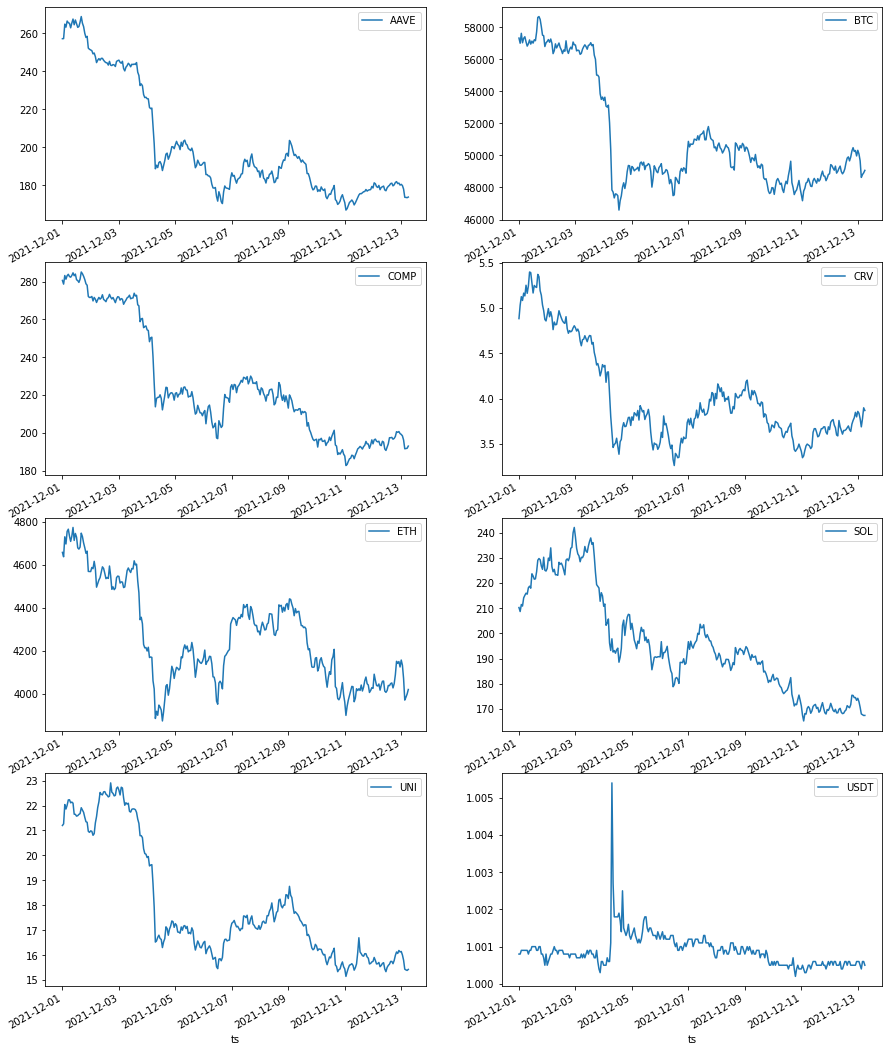

In [21]:
plot('open')

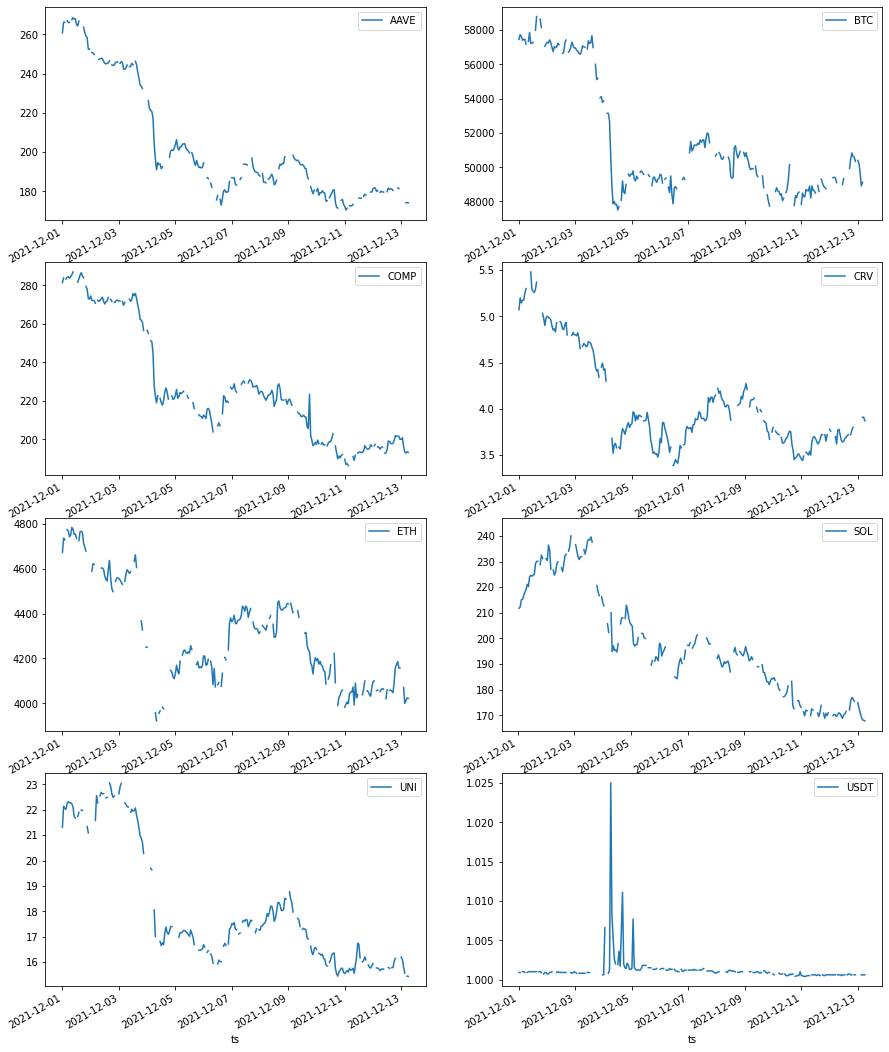

In [22]:
plot('high')

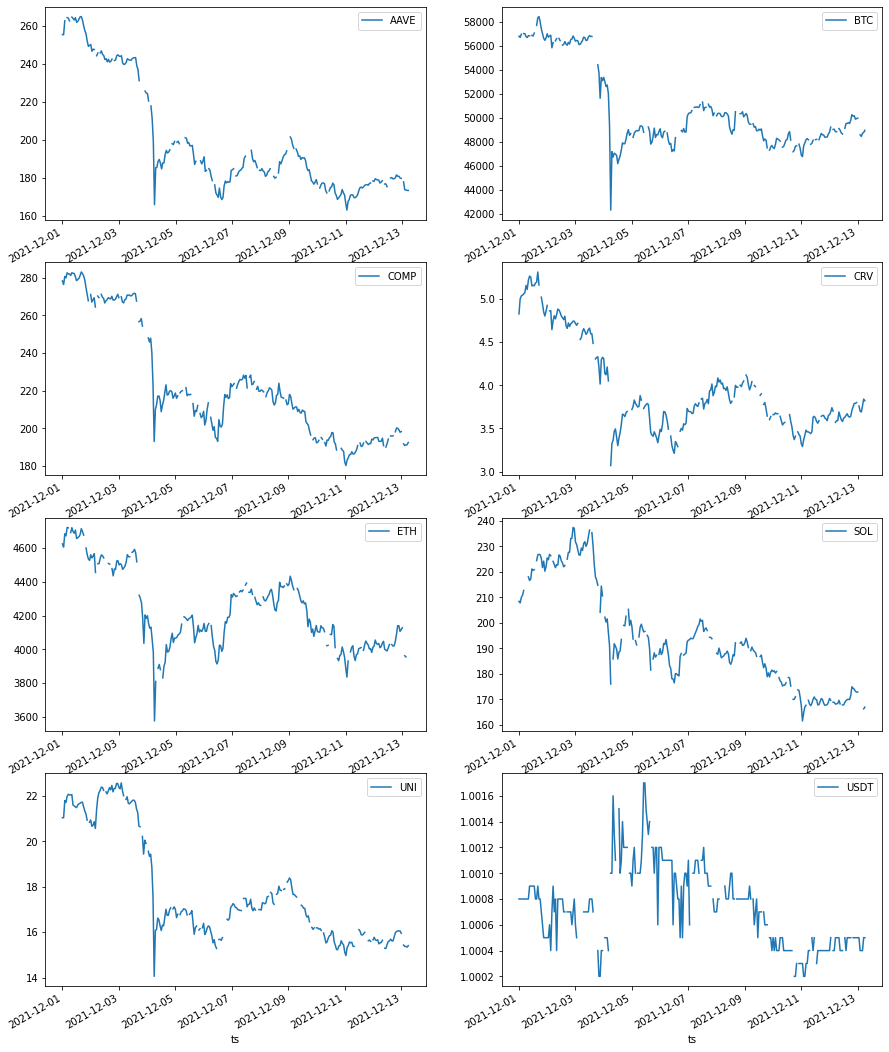

In [23]:
plot('low')

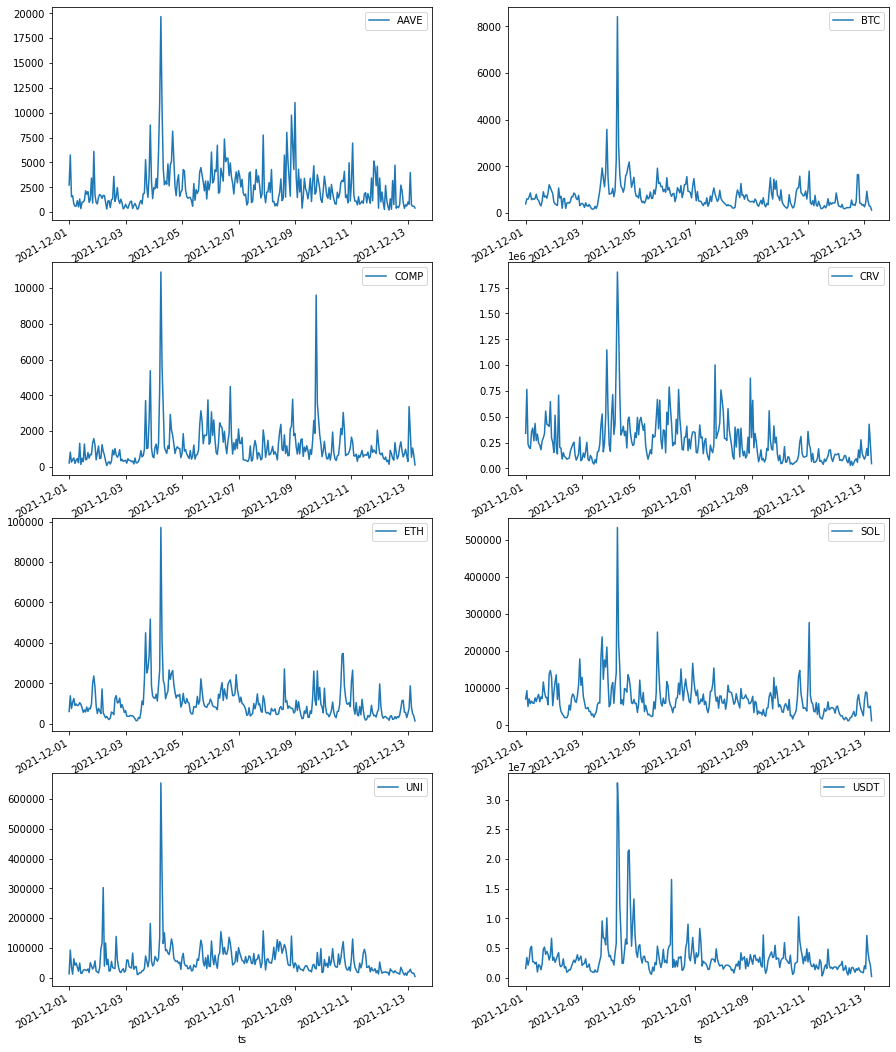

In [24]:
plot('volume')

The plots for 'close' appear to have some outlier values that will be addressed

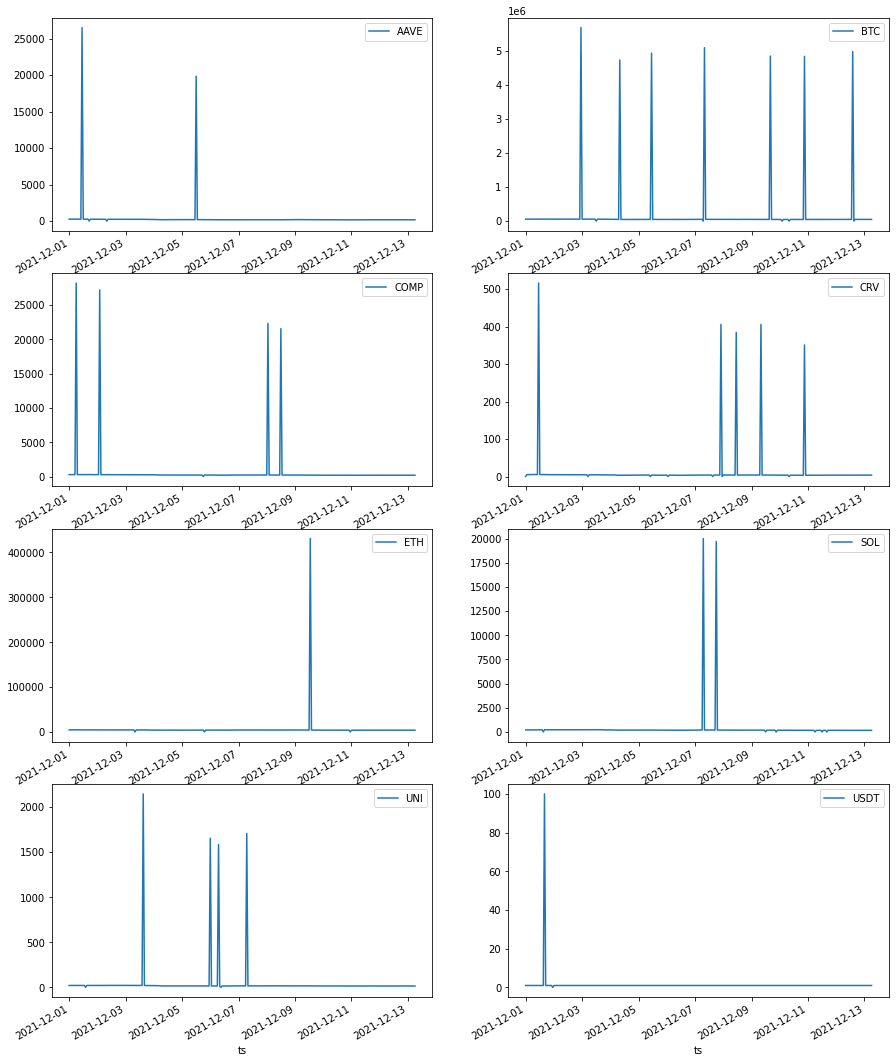

In [25]:
plot('close')

Identifying high and low outliers as those which are double the open price or half the open price

In [26]:
#Replacing outlier with average of high and low price if avaiable
df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5) & df.high.notnull() & df.low.notnull() , 'close'] = 0.5 * (df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5) & df.high.notnull() & df.low.notnull(), 'high'] + \
                                                                                                                          df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5) & df.high.notnull() & df.low.notnull(), 'low'])

In [27]:
#If high and low price is not avaiable, replace the outlier with the open price
df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5), 'close'] = df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5), 'open'] 

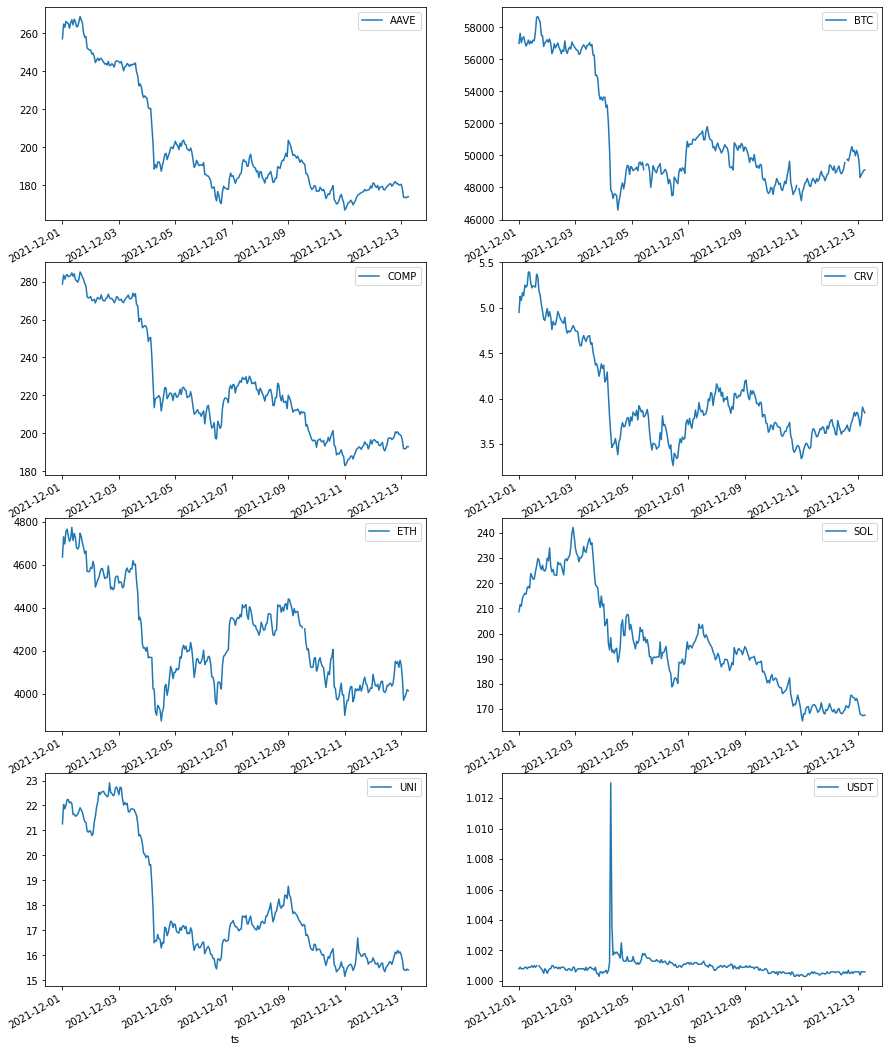

In [28]:
plot('close')

### Filling volumeUSD

In [29]:
df['volumeUSD'] = df['volume'] * df['close']

In [30]:
df[['volumeUSD']]

,volumeUSD
ts,
2021-12-02 23:00:00,1.142900e+05
2021-12-04 12:00:00,9.098847e+05
2021-12-05 07:00:00,3.022482e+05
2021-12-07 00:00:00,7.706193e+05
2021-12-07 02:00:00,4.625910e+05
...,...
2021-12-13 01:00:00,1.552901e+06
2021-12-13 02:00:00,7.136713e+06
2021-12-13 03:00:00,4.340487e+06


### Calculate volumeUSD by chain

In [31]:
df.groupby('chain')['volumeUSD'].sum().to_frame()

,volumeUSD
chain,
BTC,1.087590e+10
ETH,1.364326e+10
SOL,4.076712e+09
USDT,1.003057e+09
